In [1]:
import numpy as np

def one_hot(state):
    # 벡터 준비
    HEIGHT, WIDTH = 3, 4
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)
    
    # state에 해당하는 원소만 1.0으로 설정
    y, x = state
    idx = WIDTH * y + x
    vec[idx] = 1.0
    
    # 배치 처리를 위해 새로운 축 추가
    return vec[np.newaxis, :]
		
state = (2, 0)
x = one_hot(state)

print(x.shape)
print(x)

(1, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


지금까지의 Q 함수: 테이블로 표현

Q는 (state, action) 쌍의 데이터를 입력받아 Q 함수의 값을 출력한다.

In [2]:
from collections import defaultdict

Q = defaultdict(lambda: 0)
state = (2, 0)
action = 0

print(Q[state, action])

0


신경망으로 구현하기 위한 방법
1. s, a -> 신경망 -> Q 함수 값
2. s -> 신경망 -> 모든 행동에 대한 Q 함수 값

첫 번째 방법은 계산 비용이 커진다. Q 함수의 최댓값을 구하는 계산 비용이 높다.

In [3]:
# pip install dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class QNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100) # 중간층의 크기
        self.l2 = L.Linear(4)  # 행동의 크기(가능한 행동의 수)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x
    
qnet = QNet()

state = (2, 0)
state = one_hot(state)

qs = qnet(state)
print(qs.shape)
print(qs)

(1, 4)
variable([[-0.1092859   0.04697072 -0.14281534 -0.1432163 ]])


In [4]:
import dezero.optimizers as optimizers

class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()                          # 신경망 초기화
        self.optimizer = optimizers.SGD(self.lr)    # 옵티마이저 생성
        self.optimizer.setup(self.qnet)             # 옵티마이저에 신경망 등록

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state)
            return qs.data.argmax()
    
    def update(self, state, action, reward, next_state, done):
        done = int(done)
        next_qs = self.qnet(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q
        
        qs = self.qnet(state)
        q = qs[:, action]
        loss = F.mean_squared_error(target, q)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data
    '''
    # if로 구현 (deprecated)
    def update(self, state, action, reward, next_state, done):
        # 다음 상태에서 최대가 되는 Q 함수의 값(next_q) 계산
        if done: # 목표 상태에 도달
            next_q = np.zeros(1) # [0.] (목표 상태에서의 Q 함수는 항상 0)
        else:
            next_qs = self.qnet(next_state)
            next_q = next_qs.max(axis=1)
            next_q.unchain() # next_q를 역전파 대상에서 제외
        
        target = self.gamma * next_q + reward
        qs = self.qnet(state)
        q = qs[:, action]
        loss = F.mean_squared_error(target, q)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data
    '''

In [5]:
from gridworld import GridWorld
env = GridWorld()
agent = QLearningAgent()

episodes = 1000
loss_history = []

for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)

        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    loss_history.append(average_loss)

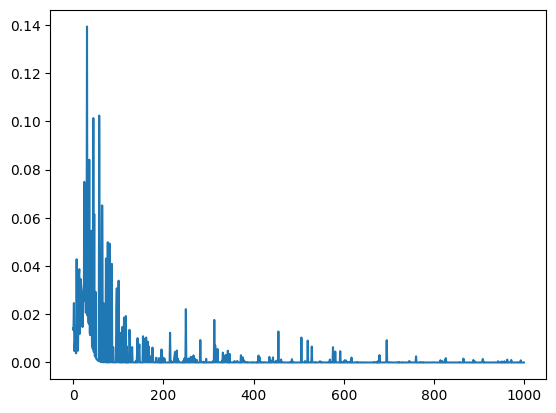

In [6]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

In [7]:
qnet(one_hot((1, 2)))[0]

variable([0.0828068  0.15063952 0.18003568 0.14471677])